<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [161]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as st
import datetime
from datetime import datetime 
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re 
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.dummy import DummyClassifier
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
nltk.download('averaged_perceptron_tagger')
from sklearn.svm import LinearSVC
import numpy
import seaborn
import matplotlib.pyplot as plot
import math
from math import log
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ahsun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ahsun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ahsun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ahsun\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [162]:
# Loads a data file from a provided file location.
def load_data(path):

    try:
        loaded_data = pd.read_csv(path)
        print(loaded_data)
    except:
        print('The required file does not exist!')    

    return loaded_data

In [163]:
train_data = load_data("IA3-train.csv")

      sentiment                                               text
0             0  @united who is in charge of making decisions o...
1             0  @united great decision making skills flight op...
2             0  @AmericanAir so what if I didn't have the fund...
3             0  @united My flying United is over...sorry. The ...
4             0  @united I believe just customer service. At la...
...         ...                                                ...
8995          1  @SouthwestAir your flight attendants are reall...
8996          1  @VirginAmerica Love the team running Gate E9 a...
8997          0  @SouthwestAir really shouldn't offer sweeps if...
8998          0  @united no HUMAN contact for 2 mths from @Amer...
8999          1  @JetBlue Landing! As usual great flight wiyh a...

[9000 rows x 2 columns]


In [164]:
val_data = load_data("IA3-dev.csv")

      sentiment                                               text
0             1  @JetBlue Then en route to the airport the rebo...
1             0  @JetBlue I’m going to miss a hugely important ...
2             0  @USAirways never flying you guys again. your c...
3             0  @AmericanAir but, what I can always rely on wh...
4             0  @JetBlue you really should be more proactive w...
...         ...                                                ...
2495          0  @united kind of unnerving to watch the guy dei...
2496          0  @united already did that at the airport and 12...
2497          0  @JetBlue and they are telling me I got to get ...
2498          0  @USAirways delayed 2 days for weather and on t...
2499          0  @SouthwestAir We've been sitting at the gate f...

[2500 rows x 2 columns]


In [165]:
import numpy as np

# Loads GloVe embeddings from a designated file location. 
#
# Invoked via:
# ge = GloVe_Embedder(path_to_embeddings)
#
# Embed single word via:
# embed = ge.embed_str(word)
#
# Embed a list of words via:
# embeds = ge.embed_list(word_list)
#
# Find nearest neighbors via:
# ge.find_k_nearest(word, k)
#
# Save vocabulary to file via:
# ge.save_to_file(path_to_file)

class GloVe_Embedder:
    def __init__(self, path):
        self.embedding_dict = {}
        self.embedding_array = []
        self.unk_emb = 0
        # Adapted from https://stackoverflow.com/questions/37793118/load-pretrained-GloVe-vectors-in-python
        with open(path,'r') as f:
            for line in f:
                split_line = line.split()
                word = split_line[0]
                embedding = np.array(split_line[1:], dtype=np.float64)
                self.embedding_dict[word] = embedding
                self.embedding_array.append(embedding.tolist())
        self.embedding_array = np.array(self.embedding_array)
        self.embedding_dim = len(self.embedding_array[0])
        self.vocab_size = len(self.embedding_array)
        self.unk_emb = np.zeros(self.embedding_dim)

    # Check if the provided embedding is the unknown embedding.
    def is_unk_embed(self, embed):
        return np.sum((embed - self.unk_emb) ** 2) < 1e-7
    
    # Check if the provided string is in the vocabulary.
    def token_in_vocab(self, x):
        if x in self.embedding_dict and not self.is_unk_embed(self.embedding_dict[x]):
            return True
        return False

    # Returns the embedding for a single string and prints a warning if
    # the string is unknown to the vocabulary.
    # 
    # If indicate_unk is set to True, the return type will be a tuple of 
    # (numpy array, bool) with the bool indicating whether the returned 
    # embedding is the unknown embedding.
    #
    # If warn_unk is set to False, the method will no longer print warnings
    # when used on unknown strings.
    def embed_str(self, x, indicate_unk = False, warn_unk = True):
        if self.token_in_vocab(x):
            if indicate_unk:
                return (self.embedding_dict[x], False)
            else:
                return self.embedding_dict[x]
        else:
            if warn_unk:
                    print("Warning: provided word is not part of the vocabulary!")
            if indicate_unk:
                return (self.unk_emb, True)
            else:
                return self.unk_emb

    # Returns an array containing the embeddings of each vocabulary token in the provided list.
    #
    # If include_unk is set to False, the returned list will not include any unknown embeddings.
    def embed_list(self, x, include_unk = True):
        if include_unk:
            embeds = [self.embed_str(word, warn_unk = False).tolist() for word in x]
        else:
            embeds_with_unk = [self.embed_str(word, indicate_unk=True, warn_unk = False) for word in x]
            embeds = [e[0].tolist() for e in embeds_with_unk if not e[1]]
            if len(embeds) == 0:
                print("No known words in input:" + str(x))
                embeds = [self.unk_emb.tolist()]
        return np.array(embeds)
    
    # Finds the vocab words associated with the k nearest embeddings of the provided word. 
    # Can also accept an embedding vector in place of a string word.
    # Return type is a nested list where each entry is a word in the vocab followed by its 
    # distance from whatever word was provided as an argument.
    def find_k_nearest(self, word, k, warn_about_unks = True):
        if type(word) == str:
            word_embedding, is_unk = self.embed_str(word, indicate_unk = True)
        else:
            word_embedding = word
            is_unk = False
        if is_unk and warn_about_unks:
            print("Warning: provided word is not part of the vocabulary!")

        all_distances = np.sum((self.embedding_array - word_embedding) ** 2, axis = 1) ** 0.5
        distance_vocab_index = [[w, round(d, 5)] for w,d,i in zip(self.embedding_dict.keys(), all_distances, range(len(all_distances)))]
        distance_vocab_index = sorted(distance_vocab_index, key = lambda x: x[1], reverse = False)
        return distance_vocab_index[:k]

    def save_to_file(self, path):
        with open(path, 'w') as f:
            for k in self.embedding_dict.keys():
                embedding_str = " ".join([str(round(s, 5)) for s in self.embedding_dict[k].tolist()])
                string = k + " " + embedding_str
                f.write(string + "\n")

In [166]:
ge = GloVe_Embedder("GloVe_Embedder_data.txt")

In [167]:
list_of_words = ['flight', 'good', 'terrible', 'help' , 'late']

In [168]:
embeds = ge.embed_list(list_of_words)

In [169]:
print(embeds.shape)

(5, 200)


In [170]:
word = 'flight'

In [171]:
embed = ge.embed_str(word)

In [172]:
embed

array([-1.6572e-01, -8.3950e-02,  2.2570e-02,  3.9720e-02,  3.0814e-01,
        1.7639e-01,  2.8357e-01,  5.5700e-03, -9.5600e-03,  1.4846e-01,
        4.8067e-01,  2.5237e-01, -4.3009e-01,  1.6862e-01,  1.2911e-01,
       -5.9924e-01, -1.3999e-01,  4.9635e-01, -8.2510e-02, -2.6530e-01,
       -2.1277e-01, -2.2453e-01,  3.0011e-01, -2.8075e-01,  5.1310e-02,
        1.0421e+00, -6.7080e-02, -5.7052e-01,  8.7370e-02, -4.3915e-01,
       -8.1000e-03,  5.2400e-03,  2.6832e-01, -6.5057e-01, -6.3500e-02,
        6.0998e-01, -7.6290e-01,  1.5033e-01,  9.2465e-01,  1.2769e-01,
       -3.1095e-01,  2.4462e-01,  9.2752e-01, -9.8065e-01,  3.0698e-01,
       -9.4610e-01, -1.6245e-01, -2.9793e-01,  4.7237e-01,  3.2092e-01,
       -2.7117e-01, -4.8036e-01,  1.8380e-02, -1.4158e-01, -3.4337e-01,
        1.1486e-01,  2.1472e-01,  7.0729e-01, -2.4157e-01, -2.1553e-01,
        3.9954e-01,  4.6465e-01,  4.1700e-01,  2.0390e-01, -3.0071e-01,
        1.1968e-01,  2.6760e-01,  1.3740e-02,  3.3544e-01, -8.09

In [173]:
nearest_list = []
for word in embeds:
    nearest_list.append(ge.find_k_nearest(word, 30))

In [174]:
nearest_list

[[['flight', 0.0],
  ['plane', 4.45689],
  ['flights', 5.32675],
  ['boarding', 5.4882],
  ['airline', 5.58355],
  ['jet', 5.59065],
  ['flying', 5.59299],
  ['heading', 5.6417],
  ['arrival', 5.70659],
  ['airlines', 5.85213],
  ['travel', 5.89098],
  ['shuttle', 5.90023],
  ['delayed', 5.91624],
  ['landing', 5.92666],
  ['route', 5.96298],
  ['airplane', 6.00258],
  ['safe', 6.00877],
  ['booking', 6.01374],
  ['fly', 6.02409],
  ['departure', 6.04052],
  ['waiting', 6.04259],
  ['landed', 6.09697],
  ['journey', 6.12156],
  ['passengers', 6.12345],
  ['transit', 6.12451],
  ['delay', 6.13663],
  ['crew', 6.14757],
  ['pilot', 6.17311],
  ['trip', 6.18669],
  ['taxi', 6.20436]],
 [['good', 0.0],
  ['great', 3.64107],
  ['well', 3.96383],
  ['nice', 4.00469],
  ['better', 4.19665],
  ['night', 4.30113],
  ['bad', 4.34788],
  ['morning', 4.43596],
  ['way', 4.52146],
  ['hope', 4.54451],
  ['but', 4.55671],
  ['too', 4.57775],
  ['really', 4.60558],
  ['right', 4.68877],
  ['though', 

In [175]:
len(nearest_list)

5

In [176]:
nearest_array = np.asarray(nearest_list)

In [177]:
nearest_array

array([[['flight', '0.0'],
        ['plane', '4.45689'],
        ['flights', '5.32675'],
        ['boarding', '5.4882'],
        ['airline', '5.58355'],
        ['jet', '5.59065'],
        ['flying', '5.59299'],
        ['heading', '5.6417'],
        ['arrival', '5.70659'],
        ['airlines', '5.85213'],
        ['travel', '5.89098'],
        ['shuttle', '5.90023'],
        ['delayed', '5.91624'],
        ['landing', '5.92666'],
        ['route', '5.96298'],
        ['airplane', '6.00258'],
        ['safe', '6.00877'],
        ['booking', '6.01374'],
        ['fly', '6.02409'],
        ['departure', '6.04052'],
        ['waiting', '6.04259'],
        ['landed', '6.09697'],
        ['journey', '6.12156'],
        ['passengers', '6.12345'],
        ['transit', '6.12451'],
        ['delay', '6.13663'],
        ['crew', '6.14757'],
        ['pilot', '6.17311'],
        ['trip', '6.18669'],
        ['taxi', '6.20436']],

       [['good', '0.0'],
        ['great', '3.64107'],
        ['wel

In [178]:
nearest_array = nearest_array.flatten()

In [179]:
filtered_list = list(filter(lambda x: (x.isalpha()), nearest_array))

In [180]:
filtered_list_of_numbers = [float(x) for x in list(filter(lambda x: (not x.isalpha()), nearest_array))]

In [181]:
filtered_list_of_numbers

[0.0,
 4.45689,
 5.32675,
 5.4882,
 5.58355,
 5.59065,
 5.59299,
 5.6417,
 5.70659,
 5.85213,
 5.89098,
 5.90023,
 5.91624,
 5.92666,
 5.96298,
 6.00258,
 6.00877,
 6.01374,
 6.02409,
 6.04052,
 6.04259,
 6.09697,
 6.12156,
 6.12345,
 6.12451,
 6.13663,
 6.14757,
 6.17311,
 6.18669,
 6.20436,
 0.0,
 3.64107,
 3.96383,
 4.00469,
 4.19665,
 4.30113,
 4.34788,
 4.43596,
 4.52146,
 4.54451,
 4.55671,
 4.57775,
 4.60558,
 4.68877,
 4.69955,
 4.70148,
 4.70444,
 4.7177,
 4.76147,
 4.76949,
 4.78543,
 4.81795,
 4.83542,
 4.84457,
 4.85276,
 4.86179,
 4.89081,
 4.9018,
 4.90492,
 4.90592,
 0.0,
 2.8716,
 4.31316,
 5.24022,
 5.35858,
 5.45579,
 5.49845,
 5.56903,
 5.58304,
 5.59716,
 5.631,
 5.64538,
 5.67322,
 5.71411,
 5.73043,
 5.73712,
 5.78009,
 5.78166,
 5.80851,
 5.82791,
 5.86491,
 5.87343,
 5.88777,
 5.89628,
 5.9003,
 5.90768,
 5.93984,
 5.94033,
 5.97906,
 5.98936,
 0.0,
 4.66871,
 4.71355,
 4.8564,
 5.26437,
 5.27073,
 5.33329,
 5.35559,
 5.3827,
 5.39777,
 5.40568,
 5.42209,
 5.547

In [182]:
len(filtered_list)

150

In [183]:
filtered_list

['flight',
 'plane',
 'flights',
 'boarding',
 'airline',
 'jet',
 'flying',
 'heading',
 'arrival',
 'airlines',
 'travel',
 'shuttle',
 'delayed',
 'landing',
 'route',
 'airplane',
 'safe',
 'booking',
 'fly',
 'departure',
 'waiting',
 'landed',
 'journey',
 'passengers',
 'transit',
 'delay',
 'crew',
 'pilot',
 'trip',
 'taxi',
 'good',
 'great',
 'well',
 'nice',
 'better',
 'night',
 'bad',
 'morning',
 'way',
 'hope',
 'but',
 'too',
 'really',
 'right',
 'though',
 'there',
 'day',
 'luck',
 'sure',
 'it',
 'thing',
 'pretty',
 'think',
 'have',
 'all',
 'yes',
 'very',
 'again',
 'work',
 'yeah',
 'terrible',
 'horrible',
 'awful',
 'bad',
 'brutal',
 'idea',
 'horrendous',
 'horrid',
 'shitty',
 'quite',
 'worst',
 'similar',
 'shame',
 'worse',
 'crap',
 'actual',
 'horrific',
 'bloody',
 'ridiculous',
 'such',
 'atrocious',
 'dreadful',
 'sick',
 'wtf',
 'fucking',
 'cruel',
 'seriously',
 'unreal',
 'mess',
 'however',
 'help',
 'need',
 'helping',
 'please',
 'pls',
 'l

In [184]:
filtered_embeds = ge.embed_list(filtered_list)

In [185]:
filtered_embeds.shape

(150, 200)

In [186]:
filtered_embeds

array([[-0.16572, -0.08395,  0.02257, ..., -0.28324,  0.45505,  0.14103],
       [-0.25592, -0.33874, -0.09671, ..., -0.55179,  0.38059,  0.03867],
       [-0.57264,  0.35847,  0.37772, ...,  0.24231,  0.39318,  0.93379],
       ...,
       [-0.25522,  0.0906 , -0.07389, ...,  0.14102,  0.28921,  0.4418 ],
       [ 0.18512,  0.01346, -0.12087, ...,  0.22114,  0.11646, -0.03482],
       [-0.26034,  0.26942,  0.16707, ..., -0.15519,  0.55632,  0.30085]])

In [187]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
model_pca = pca.fit_transform(filtered_embeds)
pca_df = pd.DataFrame(data = model_pca, columns = ['col1', 'col2'])

In [188]:
pca_df.shape[0]

150

In [189]:
def plot_tsne(step):
    x = 0
    while x <= tsne_df.shape[0]:
        plt.scatter(tsne_df[x:x+30]['col1'], tsne_df[x:x+30]['col2'])
        plt.legend(labels = list_of_words)
        plt.xlabel('tsne_dimension_1')
        plt.ylabel('tsne_dimension_2')
        step = str(step)
        plt.title('Vsualizing 150 words into 2-d space in TSNE ' + 'perplexity value ' + step)
        x += 30

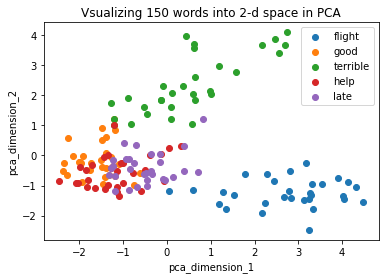

In [190]:
x = 0
while x <= pca_df.shape[0]:
    plt.scatter(pca_df[x:x+30]['col1'], pca_df[x:x+30]['col2'])
    plt.legend(labels = list_of_words)
    plt.xlabel('pca_dimension_1')
    plt.ylabel('pca_dimension_2')
    plt.title('Vsualizing 150 words into 2-d space in PCA')
    x += 30

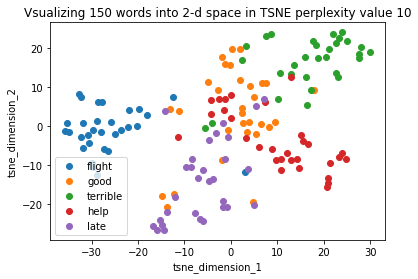

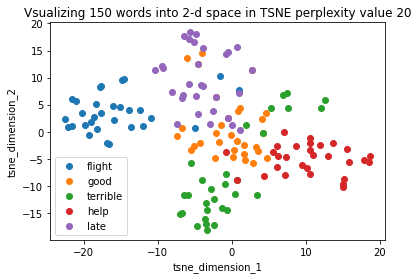

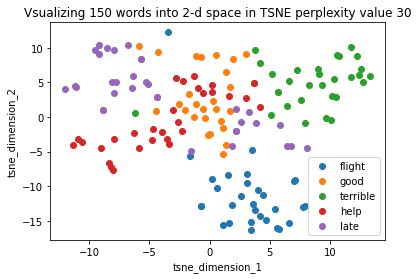

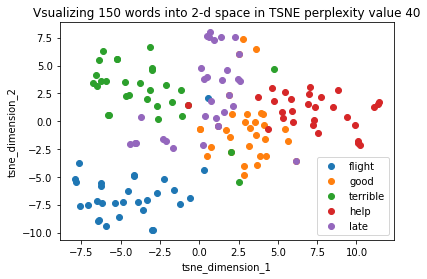

In [191]:
from sklearn.manifold import TSNE
for step in range(10, 50, 10):
    model_tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=step).fit_transform(filtered_embeds)
    tsne_df = pd.DataFrame(data = model_tsne, columns = ['col1', 'col2'])
    plot_tsne(step)
    plt.show()

In [192]:
list_of_inertia = []
list_of_clusters = []
for cluster in range(2,20,1):
    kmeans = KMeans(n_clusters=cluster, random_state=0)
    kmeans.fit(filtered_embeds)
    model_kmeans = kmeans.transform(filtered_embeds)
    list_of_inertia.append(kmeans.inertia_)
    list_of_clusters.append(cluster)

Text(0.5, 1.0, 'Inertia Vs. K-values')

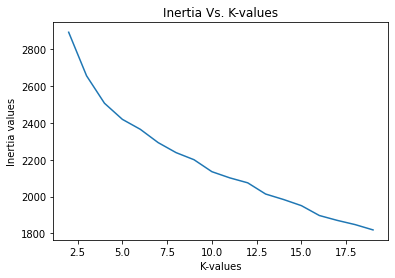

In [193]:
plt.plot(list_of_clusters, list_of_inertia)
plt.ylabel('Inertia values')
plt.xlabel('K-values')
plt.title('Inertia Vs. K-values')

In [194]:
from sklearn.metrics.cluster import normalized_mutual_info_score

In [195]:
filtered_embeds

array([[-0.16572, -0.08395,  0.02257, ..., -0.28324,  0.45505,  0.14103],
       [-0.25592, -0.33874, -0.09671, ..., -0.55179,  0.38059,  0.03867],
       [-0.57264,  0.35847,  0.37772, ...,  0.24231,  0.39318,  0.93379],
       ...,
       [-0.25522,  0.0906 , -0.07389, ...,  0.14102,  0.28921,  0.4418 ],
       [ 0.18512,  0.01346, -0.12087, ...,  0.22114,  0.11646, -0.03482],
       [-0.26034,  0.26942,  0.16707, ..., -0.15519,  0.55632,  0.30085]])

In [196]:
from numpy import random

x=random.randint(150, size=(5))

In [197]:
xyz = [0,1,2,3,4]

In [198]:
true_labels = [27, 54, 87, 112, 145]

In [199]:
words = []
for value in true_labels:
    words.append(filtered_list[value])

In [200]:
words

['pilot', 'all', 'unreal', 'want', 'wake']

In [201]:
kmeans_embeds = ge.embed_list(words)

In [202]:
kmeans_embeds.shape

(5, 200)

In [203]:
# weights_of_words = np.asarray(weights_of_words)
# weights_of_words = weights_of_words.reshape(-1, 1)

In [204]:
new_array = []
x = 150
i = 0
while x >0:
    d = [i]* 30
    new_array+=d
    x -= 30
    i += 1

In [205]:
new_array

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4]

In [206]:
from sklearn.metrics.cluster import adjusted_rand_score
list_of_predictions = []
list_of_labels = []
cluster_centers = []
cluster_size = []
for cluster in range(2,20,1):
    kmeans = KMeans(n_clusters=cluster, random_state=0)
    kmeans.fit(filtered_embeds)
    model_kmeans = kmeans.transform(filtered_embeds)
    list_of_labels.append(kmeans.labels_)
    cluster_centers.append(kmeans.cluster_centers_)
   # kmeans_prediction = kmeans.predict(kmeans_embeds)
    kmeans_prediction = kmeans.predict(filtered_embeds)
    
    print('f cluster: {}'.format(cluster), normalized_mutual_info_score(new_array, kmeans_prediction))
    list_of_predictions.append(normalized_mutual_info_score(new_array, kmeans_prediction))
    cluster_size.append(cluster)

f cluster: 2 0.3601051520996533
f cluster: 3 0.6138981869527641
f cluster: 4 0.6410376946767983
f cluster: 5 0.7094382303217028
f cluster: 6 0.6292536722906626
f cluster: 7 0.682911927834081
f cluster: 8 0.6388489415826499
f cluster: 9 0.5783991425965873
f cluster: 10 0.559444573465042
f cluster: 11 0.5821611154070353
f cluster: 12 0.5688651317457399
f cluster: 13 0.6065932244105091
f cluster: 14 0.5624987464308063
f cluster: 15 0.6017181091613001
f cluster: 16 0.5382331889745171
f cluster: 17 0.5499027161807599
f cluster: 18 0.5152653171458719
f cluster: 19 0.5415851665019153


Text(0.5, 1.0, 'Graph of Mutual Information vs Clusters')

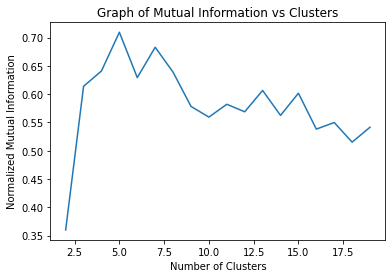

In [207]:
plt.plot( cluster_size, list_of_predictions)
plt.xlabel('Number of Clusters')
plt.ylabel('Normalized Mutual Information')
plt.title('Graph of Mutual Information vs Clusters')

In [208]:
list_of_predictions_adj = []
cluster_size_adj = []
for cluster in range(2,20,1):
    kmeans = KMeans(n_clusters=cluster, random_state=0)
    kmeans.fit(filtered_embeds)
    model_kmeans = kmeans.transform(filtered_embeds)
    list_of_labels.append(kmeans.labels_)
    cluster_centers.append(kmeans.cluster_centers_)
   # kmeans_prediction = kmeans.predict(kmeans_embeds)
    kmeans_prediction = kmeans.predict(filtered_embeds)
    
    print('f cluster: {}'.format(cluster), adjusted_rand_score(new_array, kmeans_prediction))
    list_of_predictions_adj.append(adjusted_rand_score(new_array, kmeans_prediction))
    cluster_size_adj.append(cluster)

f cluster: 2 0.1722357081181473
f cluster: 3 0.38110777201023993
f cluster: 4 0.4780653619861524
f cluster: 5 0.6068964244861813
f cluster: 6 0.4330101409403741
f cluster: 7 0.5970798321046645
f cluster: 8 0.47887643661249507
f cluster: 9 0.4068599112396771
f cluster: 10 0.360002445391908
f cluster: 11 0.37713513377800467
f cluster: 12 0.3823853849352148
f cluster: 13 0.3918508303299301
f cluster: 14 0.3009452245354132
f cluster: 15 0.4268139402018663
f cluster: 16 0.28672153347224927
f cluster: 17 0.30809463290644246
f cluster: 18 0.25395239051828045
f cluster: 19 0.25702441038004625


Text(0.5, 1.0, 'Graph of Mutual Information vs Clusters')

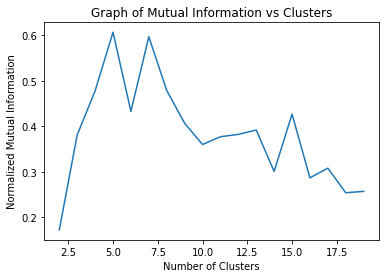

In [209]:
plt.plot( cluster_size_adj, list_of_predictions_adj)
plt.xlabel('Number of Clusters')
plt.ylabel('Normalized Mutual Information')
plt.title('Graph of Mutual Information vs Clusters')

In [210]:
from sklearn.metrics.cluster import contingency_matrix
list_of_predictions_purity = []
cluster_size_purity = []
for cluster in range(2,20,1):
    kmeans = KMeans(n_clusters=cluster, random_state=0)
    kmeans.fit(filtered_embeds)
    model_kmeans = kmeans.transform(filtered_embeds)
    list_of_labels.append(kmeans.labels_)
    cluster_centers.append(kmeans.cluster_centers_)
   # kmeans_prediction = kmeans.predict(kmeans_embeds)
    kmeans_prediction = kmeans.predict(filtered_embeds)
    cont_matrix = contingency_matrix(new_array, kmeans_prediction)
    purity = np.sum(np.amax(cont_matrix, axis=0)) / np.sum(cont_matrix)
    print('f cluster: {}'.format(cluster), purity)
    list_of_predictions_purity.append(purity)
    cluster_size_purity.append(cluster)

f cluster: 2 0.38666666666666666
f cluster: 3 0.5666666666666667
f cluster: 4 0.6933333333333334
f cluster: 5 0.8066666666666666
f cluster: 6 0.7533333333333333
f cluster: 7 0.8533333333333334
f cluster: 8 0.8266666666666667
f cluster: 9 0.7666666666666667
f cluster: 10 0.8066666666666666
f cluster: 11 0.76
f cluster: 12 0.7866666666666666
f cluster: 13 0.7866666666666666
f cluster: 14 0.7866666666666666
f cluster: 15 0.86
f cluster: 16 0.8
f cluster: 17 0.84
f cluster: 18 0.8066666666666666
f cluster: 19 0.8133333333333334


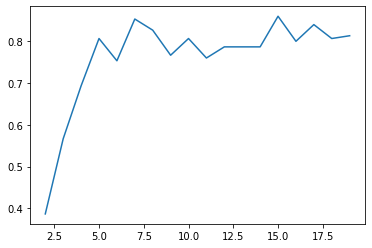

In [211]:
plt.plot(cluster_size_purity, list_of_predictions_purity)

In [212]:
print(embeds)

[[-1.6572e-01 -8.3950e-02  2.2570e-02  3.9720e-02  3.0814e-01  1.7639e-01
   2.8357e-01  5.5700e-03 -9.5600e-03  1.4846e-01  4.8067e-01  2.5237e-01
  -4.3009e-01  1.6862e-01  1.2911e-01 -5.9924e-01 -1.3999e-01  4.9635e-01
  -8.2510e-02 -2.6530e-01 -2.1277e-01 -2.2453e-01  3.0011e-01 -2.8075e-01
   5.1310e-02  1.0421e+00 -6.7080e-02 -5.7052e-01  8.7370e-02 -4.3915e-01
  -8.1000e-03  5.2400e-03  2.6832e-01 -6.5057e-01 -6.3500e-02  6.0998e-01
  -7.6290e-01  1.5033e-01  9.2465e-01  1.2769e-01 -3.1095e-01  2.4462e-01
   9.2752e-01 -9.8065e-01  3.0698e-01 -9.4610e-01 -1.6245e-01 -2.9793e-01
   4.7237e-01  3.2092e-01 -2.7117e-01 -4.8036e-01  1.8380e-02 -1.4158e-01
  -3.4337e-01  1.1486e-01  2.1472e-01  7.0729e-01 -2.4157e-01 -2.1553e-01
   3.9954e-01  4.6465e-01  4.1700e-01  2.0390e-01 -3.0071e-01  1.1968e-01
   2.6760e-01  1.3740e-02  3.3544e-01 -8.0908e-01 -1.9069e-01  2.4530e-01
  -5.8880e-02 -8.7979e-01  9.5020e-01 -1.7699e-01 -2.2566e-01  1.2184e-01
   5.2940e-01  1.7246e-01  9.9000e-03 

In [213]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))
n_items = take(5, ge.embedding_dict.items())
for item in n_items:
    print(len(item[1]))

200
200
200
200
200


In [214]:
print(len(ge.embedding_dict.keys()))

12622


In [215]:
from nltk.stem import WordNetLemmatizer 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.stem.snowball import SnowballStemmer

In [216]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join(lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text))
def stem_text(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(text)

text = "leaves"
text = lemmatize_text(text)
text = stem_text(text)
print(text)

leaf


In [217]:
vocab = {}
ge = GloVe_Embedder("GloVe_Embedder_data.txt")
print(len(ge.embedding_dict.items()))
for word,emb in ge.embedding_dict.items():
    vocab[word] = emb
    text = lemmatize_text(word)
    vocab[text] = emb
    text = stem_text(word)
    vocab[text] = emb

#     if text!=word:
#         print(word,text)
new_vocab = vocab
vocab = [(word,vocab[word]) for word in vocab]  

print(len(vocab))
print(vocab[50])

12622
15759
('1019', array([-0., -0.,  0.,  0., -0.,  0., -0.,  0., -0., -0.,  0.,  0., -0.,
       -0.,  0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,  0.,
        0., -0., -0., -0.,  0., -0., -0., -0.,  0., -0., -0., -0.,  0.,
        0.,  0., -0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,
       -0., -0., -0., -0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0., -0.,
        0.,  0.,  0.,  0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,  0.,
        0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,
       -0., -0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,  0., -0., -0.,
       -0., -0.,  0., -0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,  0.,
        0., -0., -0., -0.,  0., -0., -0., -0., -0., -0.,  0.,  0., -0.,
        0.,  0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,
        0., -0., -0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0.,  0., -0.,
       -0.,  0., -0., -0.,  0.,  0., -0., -

In [218]:
with open("new_vocab.txt", "w") as f:
    for word,emb in new_vocab.items():
        string = word
        for num in emb:
            string = string+" "+str(num)
        f.write(f'{string}\n')

In [219]:
ge = GloVe_Embedder("new_vocab.txt")
list_of_words = ['flight', 'flight', 'terrible', 'help' , 'late']
word_weights = { x:list_of_words.count(x) for x in list_of_words}
print(word_weights)
a = ge.embed_list([w for w in word_weights])
print(a)
weights = [word_weights[w] for w in word_weights]
print(weights)
avg = np.average(a)
print(avg)

{'flight': 2, 'terrible': 1, 'help': 1, 'late': 1}
[[-5.7264e-01  3.5847e-01  3.7772e-01  1.7483e-01  4.2896e-01 -4.3311e-01
   2.5458e-01 -3.4977e-01 -8.4550e-02  2.8490e-01  3.3007e-01  5.1580e-02
  -1.2637e+00  1.5140e-02 -1.2770e-02 -7.4526e-01 -9.6853e-01  3.2440e-01
  -2.7002e-01 -2.7417e-01  6.2170e-02 -6.7265e-01  2.3016e-01 -2.7007e-01
   1.3676e-01  1.1842e+00  7.0742e-01 -5.4290e-01  2.3134e-01 -8.6747e-01
   5.0020e-02  2.3854e-01 -3.9610e-01 -5.7797e-01 -2.8019e-01  7.9970e-02
  -2.6871e-01  2.2040e-02  5.6883e-01 -3.5892e-01  2.1059e-01 -2.5440e-02
   6.6026e-01 -1.1235e+00 -2.2264e-01 -1.2676e+00 -1.0950e-01 -8.7628e-01
   1.9742e-01  2.3276e-01 -3.1823e-01 -6.1293e-01  3.6700e-01 -1.4953e-01
  -3.1428e-01  5.0690e-01  7.4110e-02  9.2500e-02 -6.2540e-01 -7.0250e-02
  -3.1023e-01  3.2032e-01  4.7524e-01  1.1826e-01 -3.9972e-01  5.7270e-02
   4.2885e-01  4.7902e-01  3.5050e-01 -6.2062e-01  8.3960e-02 -1.3004e-01
   4.6473e-01 -6.7550e-01  5.7303e-01  2.1650e-01 -7.9069e-01

In [220]:
# Loads a data file from a provided file location.
def load_data(path):
    try:
        loaded_data = pd.read_csv(path)
        display(loaded_data)
    except:
        print('The required file does not exist!')    

    return loaded_data

In [221]:
train_data = load_data("IA3-train.csv")
val_data = load_data("IA3-dev.csv")

,sentiment,text
0,0,@united who is in charge of making decisions o...
1,0,@united great decision making skills flight op...
2,0,@AmericanAir so what if I didn't have the fund...
3,0,@united My flying United is over...sorry. The ...
4,0,@united I believe just customer service. At la...
...,...,...
8995,1,@SouthwestAir your flight attendants are reall...
8996,1,@VirginAmerica Love the team running Gate E9 a...
8997,0,@SouthwestAir really shouldn't offer sweeps if...
8998,0,@united no HUMAN contact for 2 mths from @Amer...


,sentiment,text
0,1,@JetBlue Then en route to the airport the rebo...
1,0,@JetBlue I’m going to miss a hugely important ...
2,0,@USAirways never flying you guys again. your c...
3,0,"@AmericanAir but, what I can always rely on wh..."
4,0,@JetBlue you really should be more proactive w...
...,...,...
2495,0,@united kind of unnerving to watch the guy dei...
2496,0,@united already did that at the airport and 12...
2497,0,@JetBlue and they are telling me I got to get ...
2498,0,@USAirways delayed 2 days for weather and on t...


In [222]:
def preprocess_data(data):
    stopwords = set(nltk_stopwords.words('english'))
    def delete_symbols(text):
        text = text.lower()
        text = re.sub(r"what's", "what is ", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"wa", " ", text)
        text = re.sub(r"co", " ", text)
        text = re.sub(r"http", " ", text)
        text = re.sub(r"thanks", "thank", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "can not ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
    # Leave only letters and spaces
        text = re.sub(r'[^a-zA-Z ]', ' ', text)
    # Delete extra spaces
        text = ' '.join(text.split())
        return text
    

    data['delete_symbols'] = data['text'].map(lambda x: delete_symbols(x))
    
    def remove_stopwords(text):
        text =  ' '.join([word for word in text.split() if word not in stopwords])
        return text
    
#     data['remove_stopwords'] =data['delete_symbols'].apply(remove_stopwords)
    
    data['text_lemmatized'] = data['delete_symbols'].apply(lemmatize_text)

    data['new_col'] = data['text_lemmatized'].apply(stem_text)
#     data['new_col'] = data['text_lemmatized'].apply(lemma_of_the_text)
    return data

In [223]:
train_data = preprocess_data(train_data)
val_data = preprocess_data(val_data)

In [224]:
train_data

,sentiment,text,delete_symbols,text_lemmatized,new_col
0,0,@united who is in charge of making decisions o...,united who is in charge of making decisions ov...,united who is in charge of making decision ove...,united who is in charge of making decision ove...
1,0,@united great decision making skills flight op...,united great decision making skills flight ops...,united great decision making skill flight ops ...,united great decision making skill flight ops ...
2,0,@AmericanAir so what if I didn't have the fund...,americanair so what if i did not have the fund...,americanair so what if i did not have the fund...,americanair so what if i did not have the fund...
3,0,@united My flying United is over...sorry. The ...,united my flying united is over sorry the capt...,united my flying united is over sorry the capt...,united my flying united is over sorry the capt...
4,0,@united I believe just customer service. At la...,united i believe just customer service at last...,united i believe just customer service at last...,united i believe just customer service at last...
...,...,...,...,...,...
8995,1,@SouthwestAir your flight attendants are reall...,southwestair your flight attendants are really...,southwestair your flight attendant are really ...,southwestair your flight attendant are really ...
8996,1,@VirginAmerica Love the team running Gate E9 a...,virginamerica love the team running gate e at ...,virginamerica love the team running gate e at ...,virginamerica love the team running gate e at ...
8997,0,@SouthwestAir really shouldn't offer sweeps if...,southwestair really should not offer sweeps if...,southwestair really should not offer sweep if ...,southwestair really should not offer sweep if ...
8998,0,@united no HUMAN contact for 2 mths from @Amer...,united no human ntact for mths from americanai...,united no human ntact for mths from americanai...,united no human ntact for mths from americanai...


In [225]:
features_train = [word_tokenize(tweet) for tweet in train_data['new_col']]
target_train = train_data['sentiment']
features_val= [word_tokenize(tweet) for tweet in val_data['new_col']]
target_val = val_data['sentiment']

In [226]:
features_train

[['united',
  'who',
  'is',
  'in',
  'charge',
  'of',
  'making',
  'decision',
  'over',
  'there',
  'cancelled',
  'flightling',
  'flight',
  'ua',
  's',
  'unacceptable',
  'i',
  'should',
  'be',
  'in',
  'belize',
  'right',
  'now'],
 ['united',
  'great',
  'decision',
  'making',
  'skill',
  'flight',
  'ops',
  'iah',
  'bag',
  'make',
  'a',
  'minute',
  'nnection',
  'and',
  'i',
  'do',
  'not',
  'flight',
  'pushed',
  'early',
  'disappoint'],
 ['americanair',
  'so',
  'what',
  'if',
  'i',
  'did',
  'not',
  'have',
  'the',
  'fund',
  'to',
  'purchase',
  'another',
  'ticket',
  'your',
  'error',
  'would',
  'cause',
  'my',
  'family',
  'to',
  'miss',
  'the',
  'funer'],
 ['united',
  'my',
  'flying',
  'united',
  'is',
  'over',
  'sorry',
  'the',
  'captain',
  'still',
  'had',
  'minute',
  'of',
  'pre',
  'flight',
  'preparation',
  'to',
  'make',
  'while',
  'we',
  'sat',
  'with',
  'no',
  'air'],
 ['united',
  'i',
  'believe',


In [227]:
def transform_input(data,vocab,embedder):
    rows = len(data)
    cols = len(vocab)
    x = np.zeros ((rows,cols))
    wordList = [word[0] for word in vocab]

    for i,tweet in enumerate(data):
        list_of_words = [w for w in tweet if w in wordList]
        for word in list_of_words:
            index = wordList.index(word)
            x[i][index] = np.linalg.norm(embedder.embed_str(word))
    return x        

In [228]:
x = transform_input(features_train,vocab,ge)

In [229]:
from scipy. sparse import csr_matrix
sparse_x = csr_matrix(x)

In [230]:
from sklearn.svm import SVC
import math
from math import log
c_values = numpy.logspace(-4, 5, 100)
scores = []
best = 0
best_c = 0
for c_value in c_values:
    model_train = LinearSVC(random_state=12345, C = c_value)
    model_train.fit(sparse_x , target_train)
    score = model_train.score(X = sparse_x , y = target_train)
    if score > best:
        best = score
        best_c = c_value
    scores.append(score)
    print('c_value', c_value, 'score', score)
print('best', best, 'best_c', best_c)

c_value 0.0001 score 0.9076666666666666
c_value 0.0001232846739442066 score 0.9124444444444444
c_value 0.0001519911082952933 score 0.9166666666666666
c_value 0.0001873817422860383 score 0.922
c_value 0.00023101297000831605 score 0.9263333333333333
c_value 0.0002848035868435802 score 0.9311111111111111
c_value 0.0003511191734215131 score 0.9354444444444444
c_value 0.0004328761281083057 score 0.9397777777777778
c_value 0.0005336699231206312 score 0.9432222222222222
c_value 0.0006579332246575682 score 0.9473333333333334
c_value 0.0008111308307896872 score 0.9511111111111111
c_value 0.001 score 0.955
c_value 0.0012328467394420659 score 0.9604444444444444
c_value 0.0015199110829529332 score 0.9633333333333334
c_value 0.001873817422860383 score 0.9662222222222222
c_value 0.0023101297000831605 score 0.9693333333333334
c_value 0.002848035868435802 score 0.9732222222222222
c_value 0.003511191734215131 score 0.9778888888888889
c_value 0.004328761281083062 score 0.9802222222222222
c_value 0.00533

c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.08111308307896872 score 0.9977777777777778
c_value 0.1 score 0.9977777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.12328467394420659 score 0.998
c_value 0.15199110829529347 score 0.9982222222222222


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.1873817422860385 score 0.9983333333333333
c_value 0.23101297000831605 score 0.9987777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.2848035868435802 score 0.9988888888888889
c_value 0.3511191734215131 score 0.9988888888888889


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.43287612810830617 score 0.9987777777777778
c_value 0.5336699231206312 score 0.9986666666666667


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.6579332246575682 score 0.9987777777777778
c_value 0.8111308307896873 score 0.9987777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.0 score 0.9988888888888889
c_value 1.232846739442066 score 0.9981111111111111


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.5199110829529332 score 0.9982222222222222
c_value 1.873817422860383 score 0.998


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2.310129700083158 score 0.9976666666666667
c_value 2.848035868435805 score 0.9975555555555555


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 3.5111917342151346 score 0.9974444444444445
c_value 4.328761281083062 score 0.9976666666666667


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 5.336699231206313 score 0.9966666666666667
c_value 6.5793322465756825 score 0.9968888888888889


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 8.111308307896872 score 0.9964444444444445
c_value 10.0 score 0.9957777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 12.32846739442066 score 0.9967777777777778
c_value 15.199110829529332 score 0.9962222222222222


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 18.73817422860383 score 0.9961111111111111
c_value 23.10129700083163 score 0.9965555555555555


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 28.48035868435805 score 0.9958888888888889
c_value 35.111917342151344 score 0.9958888888888889


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 43.287612810830616 score 0.9956666666666667
c_value 53.366992312063125 score 0.9965555555555555


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 65.79332246575683 score 0.9967777777777778
c_value 81.11308307896873 score 0.9967777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 100.0 score 0.9966666666666667
c_value 123.28467394420659 score 0.9976666666666667


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 151.99110829529332 score 0.9974444444444445
c_value 187.3817422860383 score 0.9976666666666667


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 231.01297000831627 score 0.9976666666666667
c_value 284.8035868435805 score 0.9978888888888889


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 351.11917342151344 score 0.9985555555555555
c_value 432.87612810830615 score 0.9976666666666667


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 533.6699231206312 score 0.9974444444444445
c_value 657.9332246575682 score 0.9981111111111111


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 811.1308307896873 score 0.9968888888888889
c_value 1000.0 score 0.9981111111111111


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1232.8467394420659 score 0.9976666666666667
c_value 1519.9110829529332 score 0.9901111111111112


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1873.8174228603868 score 0.9833333333333333
c_value 2310.129700083163 score 0.9944444444444445


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2848.035868435805 score 0.9953333333333333
c_value 3511.1917342151346 score 0.9981111111111111


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 4328.7612810830615 score 0.9975555555555555
c_value 5336.699231206313 score 0.9812222222222222


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 6579.332246575683 score 0.997
c_value 8111.308307896872 score 0.992


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 10000.0 score 0.9975555555555555
c_value 12328.467394420684 score 0.9868888888888889


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 15199.11082952933 score 0.9948888888888889
c_value 18738.174228603868 score 0.9967777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 23101.29700083158 score 0.9953333333333333
c_value 28480.35868435805 score 0.9977777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 35111.917342151275 score 0.9986666666666667
c_value 43287.612810830615 score 0.997


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 53366.99231206302 score 0.9951111111111111
c_value 65793.32246575682 score 0.9966666666666667
c_value 81113.08307896889 score 0.9973333333333333
c_value 100000.0 score 0.9966666666666667
best 0.9988888888888889 best_c 0.2848035868435802


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [231]:
x_val  = transform_input(features_val,vocab,ge)
sparse_x_val = csr_matrix(x_val)

In [232]:
c_values = numpy.logspace(-4, 4, 100)
scores = []
best = 0
best_c = 0
for c_value in c_values:
    model_valid = LinearSVC(random_state=12345, C = c_value)
    model_valid.fit(sparse_x, target_train)
    score_val = model_valid.score(X = sparse_x_val, y = target_val)
    if score_val > best:
        best = score_val
        best_c = c_value
    scores.append(score_val)
    print('c_value', c_value, 'score', score_val)
print('best', best, 'best_c', best_c)  

c_value 0.0001 score 0.8984
c_value 0.00012045035402587823 score 0.9024
c_value 0.000145082877849594 score 0.9048
c_value 0.0001747528400007683 score 0.9092
c_value 0.00021049041445120198 score 0.9116
c_value 0.00025353644939701115 score 0.914
c_value 0.0003053855508833416 score 0.9172
c_value 0.0003678379771828634 score 0.9184
c_value 0.0004430621457583882 score 0.9188
c_value 0.0005336699231206312 score 0.9168
c_value 0.0006428073117284319 score 0.9196
c_value 0.000774263682681127 score 0.9208
c_value 0.0009326033468832199 score 0.9192
c_value 0.0011233240329780276 score 0.9192
c_value 0.0013530477745798076 score 0.9196
c_value 0.0016297508346206436 score 0.9172
c_value 0.0019630406500402726 score 0.9172
c_value 0.002364489412645407 score 0.9184
c_value 0.002848035868435802 score 0.9188
c_value 0.003430469286314919 score 0.9184
c_value 0.0041320124001153384 score 0.9196
c_value 0.004977023564332114 score 0.9188
c_value 0.005994842503189409 score 0.9196
c_value 0.007220809018385471 sc

c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.06734150657750829 score 0.908
c_value 0.08111308307896872 score 0.9072


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.09770099572992257 score 0.9052
c_value 0.1176811952434999 score 0.9032


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.14174741629268062 score 0.902
c_value 0.1707352647470692 score 0.9


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.20565123083486536 score 0.8968
c_value 0.24770763559917114 score 0.8972


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.298364724028334 score 0.8984
c_value 0.3593813663804629 score 0.8972


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.43287612810830617 score 0.8984
c_value 0.521400828799969 score 0.8968


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.6280291441834259 score 0.8948
c_value 0.7564633275546291 score 0.892


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.9111627561154896 score 0.8924
c_value 1.0974987654930568 score 0.892


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.3219411484660315 score 0.888
c_value 1.592282793341094 score 0.886


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.9179102616724888 score 0.8864
c_value 2.310129700083163 score 0.8872


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2.782559402207126 score 0.8852
c_value 3.351602650938848 score 0.886


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 4.037017258596558 score 0.8864
c_value 4.862601580065354 score 0.886


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 5.857020818056673 score 0.8864
c_value 7.054802310718645 score 0.8872


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 8.497534359086455 score 0.8848
c_value 10.235310218990268 score 0.8844


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 12.328467394420684 score 0.8832
c_value 14.849682622544666 score 0.8812


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 17.886495290574352 score 0.884
c_value 21.544346900318867 score 0.8828
c_value 25.950242113997373 score 0.8816
c_value 31.257158496882415 score 0.8844


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 37.649358067924716 score 0.884
c_value 45.34878508128591 score 0.8816


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 54.62277217684348 score 0.8816
c_value 65.79332246575683 score 0.8804


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 79.24828983539186 score 0.8808
c_value 95.45484566618347 score 0.8816


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 114.9756995397738 score 0.8808
c_value 138.48863713938746 score 0.8824


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 166.81005372000593 score 0.8804
c_value 200.923300256505 score 0.8824


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 242.01282647943833 score 0.8828
c_value 291.5053062825182 score 0.8808


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 351.11917342151344 score 0.8832
c_value 422.9242874389508 score 0.8828


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 509.4138014816386 score 0.88
c_value 613.5907273413176 score 0.8808


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 739.072203352579 score 0.8804
c_value 890.2150854450392 score 0.886


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1072.2672220103254 score 0.8808
c_value 1291.5496650148852 score 0.8812


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1555.6761439304755 score 0.8796
c_value 1873.8174228603868 score 0.8792


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2257.0197196339213 score 0.882
c_value 2718.5882427329457 score 0.8804


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 3274.5491628777318 score 0.8804
c_value 3944.206059437664 score 0.878


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 4750.810162102803 score 0.8812
c_value 5722.3676593502205 score 0.8804


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 6892.61210434971 score 0.8776
c_value 8302.175681319752 score 0.8768
c_value 10000.0 score 0.8788
best 0.9208 best_c 0.000774263682681127


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
